In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../combined_df.csv')
df.head()

,subreddit,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,lix,smog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,adhd,Lethargic/Depressed when off meds First I'll g...,5.400816,6.505840,5.555245,81.416541,68.047619,9.145306,31.706803,9.387100,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.095341,0.000000,0.0,0.086429
1,adhd,Concerta not working on the first day?! Update...,2.980698,5.751419,4.789892,76.862769,79.896552,8.314655,27.683190,9.017664,...,0.0,0.0,0.0,0.099106,0.000000,0.0,0.290114,0.000000,0.0,0.000000
2,adhd,Comorbid anxiety and ADHD-PI Medication Questi...,5.136889,6.746474,6.981667,69.052500,69.148148,10.733333,34.240741,10.793553,...,0.0,0.0,0.0,0.000000,0.117894,0.0,0.000000,0.126925,0.0,0.000000
3,adhd,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,2.841137,5.750767,4.597740,76.904579,82.383459,8.137030,27.109492,8.841846,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.303759,0.000000,0.0,0.000000
4,adhd,I absolutely hate being so motivated but equal...,5.781923,7.779519,6.423590,72.163077,68.102564,9.302564,37.358974,9.725611,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [3]:
df = df[['subreddit', 'post']]
df.head()

,subreddit,post
0,adhd,Lethargic/Depressed when off meds First I'll g...
1,adhd,Concerta not working on the first day?! Update...
2,adhd,Comorbid anxiety and ADHD-PI Medication Questi...
3,adhd,Fist Day on Concerta 18mg UPDATE! Update!: Tha...
4,adhd,I absolutely hate being so motivated but equal...


In [4]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [5]:
# Text preprocessing (modify as needed)
df['post'] = df['post'].str.lower()  # Convert text to lowercase

In [6]:

# Create Word2Vec embeddings
sentences = [text.split() for text in df['post']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)


In [7]:

# Prepare data for the CNN model
X = df['post']
y = df['subreddit']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=300, padding='post')


In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [9]:
# Ensure the Word2Vec model has the correct vocabulary size
word2vec_vocab = word2vec_model.wv.index_to_key
word2vec_weights = word2vec_model.wv.vectors

print(f'Vocabulary size: {len(word2vec_vocab)}')
print(f'Embedding dimensions: {word2vec_weights.shape}')


Vocabulary size: 524081
Embedding dimensions: (524081, 300)


In [10]:

# Define and train the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(word2vec_vocab), output_dim=300, input_length=300, weights=[word2vec_weights], trainable=False))
model.add(Conv1D(512, 7, activation='relu'))
model.add(MaxPooling1D(7))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test)

print(classification_report(y_test_original, label_encoder.inverse_transform(y_pred_classes)))

Epoch 1/10
14980/14980 [==============================] - 2146s 143ms/step - loss: 1.3470 - accuracy: 0.5460 - val_loss: 1.1343 - val_accuracy: 0.6065
Epoch 2/10
14980/14980 [==============================] - 2132s 142ms/step - loss: 1.0996 - accuracy: 0.6204 - val_loss: 1.1026 - val_accuracy: 0.6276
Epoch 3/10
14980/14980 [==============================] - 2291s 153ms/step - loss: 1.0304 - accuracy: 0.6436 - val_loss: 1.1092 - val_accuracy: 0.6326
Epoch 4/10
14980/14980 [==============================] - 2509s 167ms/step - loss: 0.9706 - accuracy: 0.6623 - val_loss: 1.1383 - val_accuracy: 0.6321
Epoch 5/10
2341/2341 [==============================] - 336s 143ms/step
               precision    recall  f1-score   support

    addiction       0.50      0.52      0.51      1577
         adhd       0.75      0.78      0.76      9182
   alcoholism       0.66      0.47      0.55      1254
      anxiety       0.76      0.73      0.75     11419
       autism       0.88      0.49      0.63    

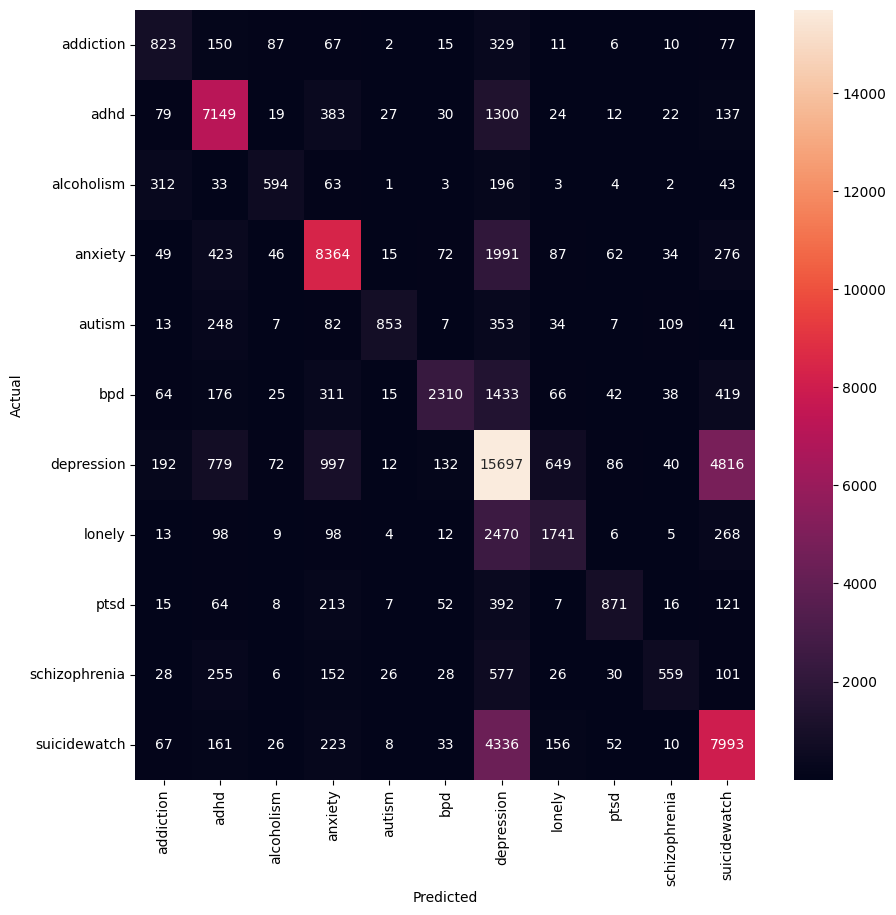

In [12]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_original, label_encoder.inverse_transform(y_pred_classes))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

